# Dogs and Cats Classification

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("tongpython/cat-and-dog")

print("Path to dataset files:", path)

100%|██████████| 218M/218M [00:01<00:00, 207MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/tongpython/cat-and-dog/versions/1


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50, MobileNetV2, EfficientNetB0, VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import precision_score, recall_score, confusion_matrix
import keras

print(f"TensorFlow Version: {tf.__version__}")
print(f"Num GPUs Available: {len(tf.config.list_physical_devices('GPU'))}")


TensorFlow Version: 2.18.0
Num GPUs Available: 0


In [4]:
base_data_path = path
train_path = os.path.join(base_data_path, 'training_set', 'training_set')
test_path = os.path.join(base_data_path, 'test_set', 'test_set')

IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32
NUM_CLASSES = 1

### Data preprocessing

In [5]:
def prepare_data_generators(train_path, test_path, IMG_HEIGHT, IMG_WIDTH, BATCH_SIZE, preprocess_input_fn):
    train_gen = ImageDataGenerator(
        rotation_range = 20,
        fill_mode='nearest',
        zoom_range=0.1,
        shear_range=0.2,
        height_shift_range=0.2,
        width_shift_range=0.2,
        horizontal_flip = True,
        preprocessing_function = preprocess_input_fn,
        validation_split = 0.15
    )

    test_gen = ImageDataGenerator(
        preprocessing_function = preprocess_input_fn
    )

    #use the flow from directory to automatically apply transformation to the data in batches
    train_ds = train_gen.flow_from_directory(
        train_path,
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size = BATCH_SIZE,
        class_mode='binary',
        color_mode = 'rgb',
        subset = 'training',
        seed = 42
    )

    val_ds = train_gen.flow_from_directory(
        train_path,
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=BATCH_SIZE,
        class_mode='binary',
        color_mode='rgb',
        subset='validation',
        seed=42
    )

    test_ds = test_gen.flow_from_directory(
        test_path,
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size = BATCH_SIZE,
        class_mode = 'binary',
        color_mode = 'rgb',
        shuffle = False
    )
    # Show the class names
    class_names = list(train_ds.class_indices.keys())
    print(f"Detected classes: {class_names}")
    print(f"Class indices: {train_ds.class_indices}")

    # SHow a few images
    plt.figure(figsize=(10, 10))

    images, labels = next(train_ds)

    for i in range(min(9, BATCH_SIZE)):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(class_names[int(labels[i])])
        plt.axis("off")
    plt.show()

    return train_ds, val_ds, test_ds, class_names

### Build and Train model Function
There are 2 phases in transfer learning:

Phase 1: Feature Extraction (Freeze weights and train a Custom Head)

Phase 2: Fine-tuning (Unfreezing and Retraining)

In [6]:
def build_and_train_model(base_model_class, model_name, train_ds,val_ds, test_ds, INPUT_SHAPE, num_classes):

    early_stopping = keras.callbacks.EarlyStopping(patience=5,restore_best_weights=True)
    learning_rate_decay = keras.callbacks.ReduceLROnPlateau(patience=3)
    # Phase 1: Feature extraction
    # Load base model: (Dont include top since we want to train our custom head)
    base_model = base_model_class(weights = 'imagenet', include_top = False, input_shape = INPUT_SHAPE)
    # Freeze all weights except the head
    base_model.trainable = False

    # Create custom binary classification head
    x = base_model.output # Get the output of the last layer of the base model (layer before the output layer) in the form (batch_size, height, width, channels)
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation = "relu")(x) #Create a dense layer and pass through relu
    x = Dropout(0.5)(x) # Add dropout layer to prevent overfitting
    prediction = Dense(num_classes, activation = "sigmoid")(x)

    # Train our newly added layers only
    model = Model(inputs = base_model.input, outputs = prediction)
    model.compile(optimizer = Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

    print("Training Phase 1 (only custom head)...")
    training_phase1 = model.fit(
        train_ds,
        epochs=10,
        validation_data=val_ds,
        verbose=1,
        callbacks=[early_stopping, learning_rate_decay]
    )

    #Phase 2: Fine tuning
    print(f"\n--- Phase 2: Fine-tuning for {model_name} ---")
    # Unfreeze base model
    base_model.trainable = True

    # Recompile model (Use small learning rate to makje small adjustments)
    model.compile(optimizer = Adam(learning_rate= 0.00001), loss='binary_crossentropy', metrics=['accuracy'])

    # Retrain entire network
    print("Training Phase 2 (fine-tuning entire network)...")
    training_phase2 = model.fit(
        train_ds,
        epochs = 10,
        validation_data = val_ds,
        callbacks=[early_stopping, learning_rate_decay],
        verbose = 1
    )
    return model


In [7]:
def evaluate_model(model, test_ds, model_name):
    test_ds.reset()
    y_pred_in_probability = model.predict(test_ds, verbose=0) #Probability predictions
    y_pred = (y_pred_in_probability > 0.5).astype(int)
    y_true = test_ds.classes

    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)

    print(f"{model_name} Precision: {precision:.4f}")
    print(f"{model_name} Recall: {recall:.4f}")

    return {
        "Model": model_name,
        "Precision": f"{precision:.2f}",
        "Recall": f"{recall:.2f}"
    }

### Main function

Found 6805 images belonging to 2 classes.
Found 1200 images belonging to 2 classes.
Found 2023 images belonging to 2 classes.
Detected classes: ['cats', 'dogs']
Class indices: {'cats': 0, 'dogs': 1}


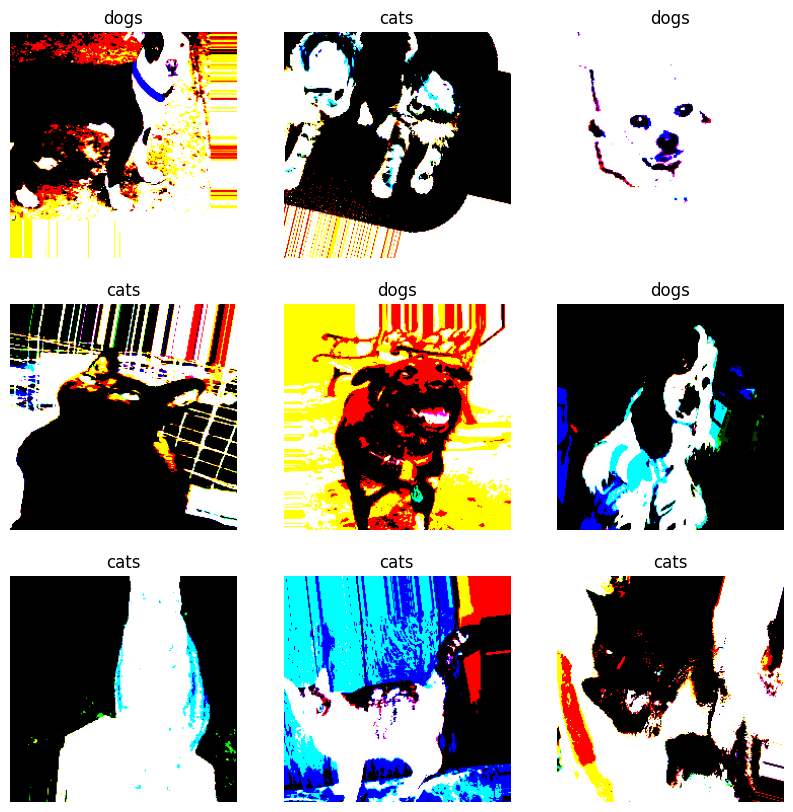

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Training Phase 1 (only custom head)...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 131s 546ms/step - accuracy: 0.9325 - loss: 0.1732 - val_accuracy: 0.9883 - val_loss: 0.0400 - learning_rate: 0.0010
Epoch 2/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 126s 508ms/step - accuracy: 0.9778 - loss: 0.0631 - val_accuracy: 0.9875 - val_loss: 0.0433 - learning_rate: 0.0010
Epoch 3/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 104s 486ms/step - accuracy: 0.9810 - loss: 0.0469 - val_accuracy: 0.9725 - val_loss: 0.0586 - learning_rate: 0.0010
Epoch 4/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 104s 489ms/step - accuracy: 0.9808 - loss: 0.0582 - val_accuracy: 0.9858 - val_loss: 0.0389 - learning_rate: 0.0010
Epoch 5/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 105s 495ms/step - accuracy: 0.9818 - loss: 0.0444 - val_accuracy: 0.9825 - val_loss: 0.0473 - learning_rate: 0.0010
Epoch 6/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 139s 482ms/step - accuracy: 0.9860 - loss: 0.0368 - val_accuracy: 0.9842 - val_loss: 0.0365 - learning_rate: 0.0010
Epoch 7/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 109s 511ms/step - accura

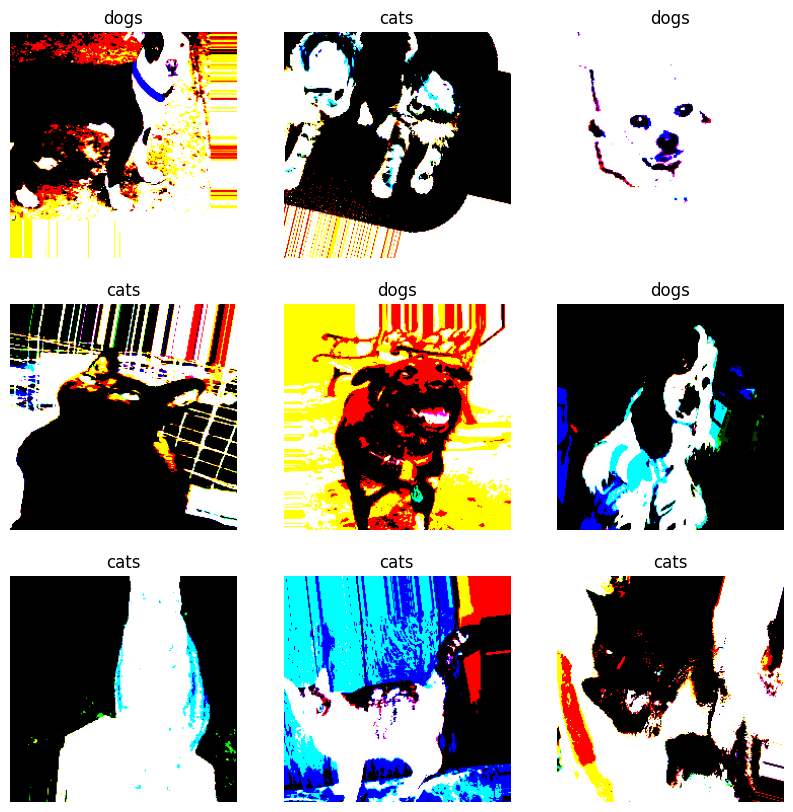

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Training Phase 1 (only custom head)...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 146s 613ms/step - accuracy: 0.8994 - loss: 0.5141 - val_accuracy: 0.9692 - val_loss: 0.0824 - learning_rate: 0.0010
Epoch 2/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 112s 526ms/step - accuracy: 0.9704 - loss: 0.0900 - val_accuracy: 0.9700 - val_loss: 0.0739 - learning_rate: 0.0010
Epoch 3/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 111s 520ms/step - accuracy: 0.9728 - loss: 0.0776 - val_accuracy: 0.9742 - val_loss: 0.0691 - learning_rate: 0.0010
Epoch 4/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 111s 520ms/step - accuracy: 0.9810 - loss: 0.0631 - val_accuracy: 0.9775 - val_loss: 0.0691 - learning_rate: 0.0010
Epoch 5/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 112s 528ms/step - accuracy: 0.9794 - loss: 0.0555 - val_accuracy: 0.9783 - val_loss: 0.0717 - learning_rate: 0.0010
Epoch 6/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 112s 525ms/step - accuracy: 0.9781 - loss: 0.0562 - val_accuracy: 0.9775 - val_loss: 0.0659 - learning_rate: 0.0010
Epoch 7/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 144s 535ms/step - accura

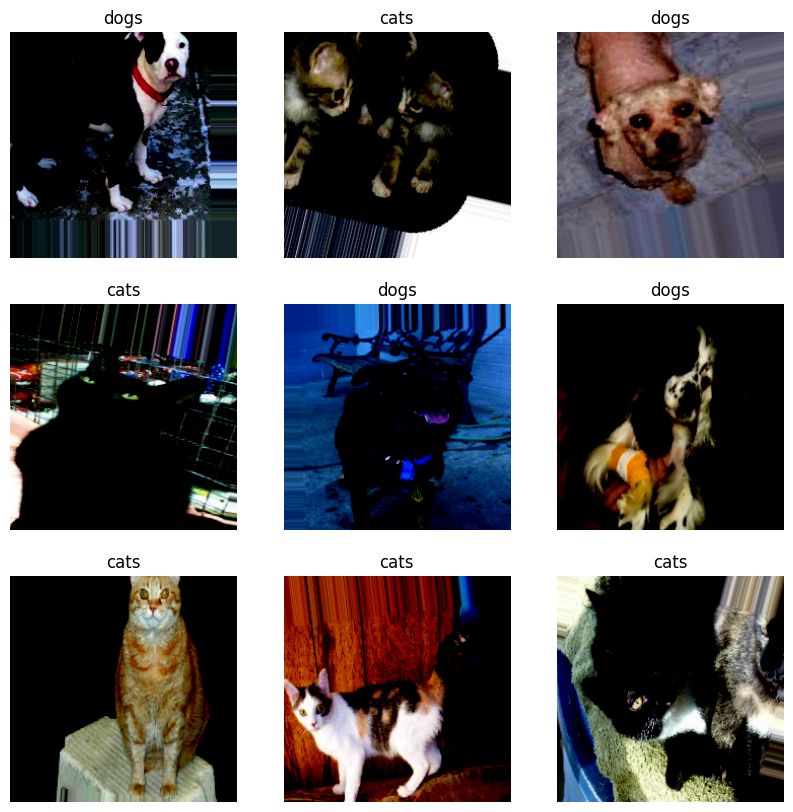

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Training Phase 1 (only custom head)...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 120s 516ms/step - accuracy: 0.9376 - loss: 0.1432 - val_accuracy: 0.9717 - val_loss: 0.0897 - learning_rate: 0.0010
Epoch 2/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 126s 465ms/step - accuracy: 0.9626 - loss: 0.1004 - val_accuracy: 0.9700 - val_loss: 0.0711 - learning_rate: 0.0010
Epoch 3/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 99s 467ms/step - accuracy: 0.9805 - loss: 0.0579 - val_accuracy: 0.9808 - val_loss: 0.0527 - learning_rate: 0.0010
Epoch 4/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 100s 468ms/step - accuracy: 0.9813 - loss: 0.0509 - val_accuracy: 0.9800 - val_loss: 0.0485 - learning_rate: 0.0010
Epoch 5/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 140s 461ms/step - accuracy: 0.9838 - loss: 0.0411 - val_accuracy: 0.9808 - val_loss: 0.0488 - learning_rate: 0.0010
Epoch 6/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 144s 472ms/step - accuracy: 0.9815 - loss: 0.0487 - val_accuracy: 0.9808 - val_loss: 0.0611 - learning_rate: 0.0010
Epoch 7/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 99s 465ms/step - accuracy

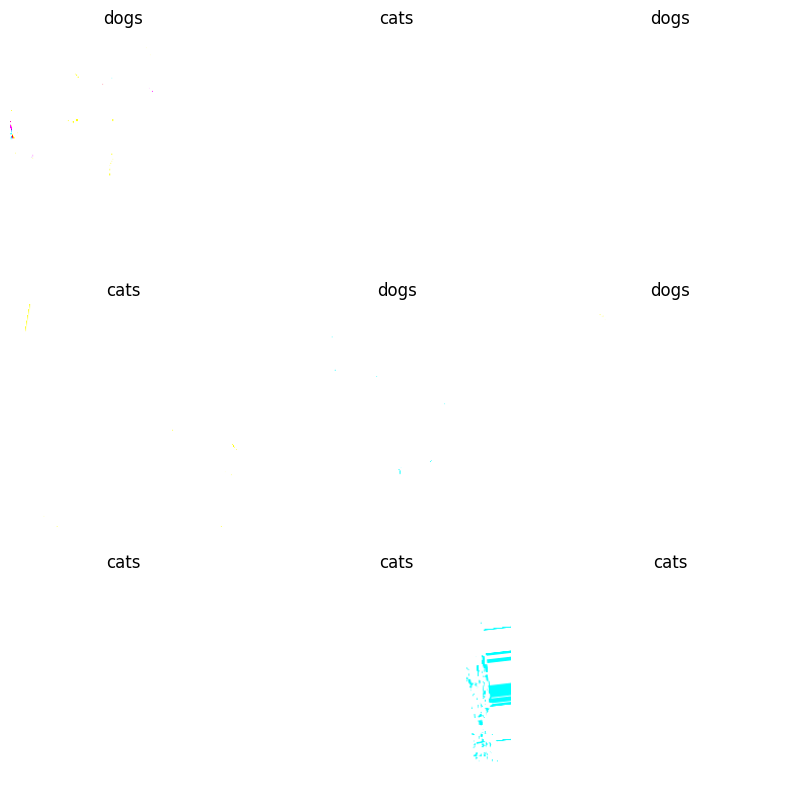

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Training Phase 1 (only custom head)...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 142s 571ms/step - accuracy: 0.9548 - loss: 0.1044 - val_accuracy: 0.9892 - val_loss: 0.0329 - learning_rate: 0.0010
Epoch 2/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 100s 470ms/step - accuracy: 0.9847 - loss: 0.0374 - val_accuracy: 0.9892 - val_loss: 0.0292 - learning_rate: 0.0010
Epoch 3/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 100s 470ms/step - accuracy: 0.9879 - loss: 0.0338 - val_accuracy: 0.9858 - val_loss: 0.0297 - learning_rate: 0.0010
Epoch 4/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 143s 478ms/step - accuracy: 0.9884 - loss: 0.0294 - val_accuracy: 0.9858 - val_loss: 0.0291 - learning_rate: 0.0010
Epoch 5/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 101s 475ms/step - accuracy: 0.9919 - loss: 0.0232 - val_accuracy: 0.9892 - val_loss: 0.0345 - learning_rate: 0.0010
Epoch 6/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 107s 502ms/step - accuracy: 0.9913 - loss: 0.0218 - val_accuracy: 0.9900 - val_loss: 0.0235 - learning_rate: 0.0010
Epoch 7/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 101s 473ms/step - accura

In [8]:
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess_input
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess_input
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess_input
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess_input

final_results = []

models_config = [
    {"class": tf.keras.applications.ResNet50, "name": "ResNet50", "preprocess_fn": resnet_preprocess_input},
    {"class": tf.keras.applications.VGG16, "name": "VGG16", "preprocess_fn": vgg_preprocess_input},
    {"class": tf.keras.applications.MobileNetV2, "name": "MobileNetV2", "preprocess_fn": mobilenet_preprocess_input},
    {"class": tf.keras.applications.EfficientNetB0, "name": "EfficientNetB0", "preprocess_fn": efficientnet_preprocess_input}
]

for config in models_config:
    train_ds, val_ds, test_ds, class_names = prepare_data_generators(
        train_path, test_path, IMG_HEIGHT, IMG_WIDTH, BATCH_SIZE, config["preprocess_fn"]
    )
    #train model
    model = build_and_train_model(
        base_model_class= config["class"],
        model_name = config["name"],
        train_ds=train_ds,
        val_ds = val_ds,
        test_ds=test_ds,
        INPUT_SHAPE=(IMG_HEIGHT, IMG_WIDTH, 3),
        num_classes=NUM_CLASSES
    )
    #evaluate
    result = evaluate_model(model, test_ds, config["name"])
    final_results.append(result)

for i in range(len(final_results)):
    print(final_results[i])




In [5]:
answers = pd.DataFrame({
    "Precision": [0.9863, 0.9872, 0.9814, 0.9881],
    "Recall": [0.9951, 0.9921, 0.9901, 0.9881]
}, index=["ResNet50", "VGG16", "MobileNetV2", "EfficientNetB0"])

answers

,Precision,Recall
ResNet50,0.9863,0.9951
VGG16,0.9872,0.9921
MobileNetV2,0.9814,0.9901
EfficientNetB0,0.9881,0.9881
